# import library


In [1]:
#넘파이 임포트
import numpy as np
#판다스 불러오기
import pandas as pd
#os라이브러리로드
import os
#텐서플로우 로드
import tensorflow as tf
#매트랩, 시본, 케라스 임포트
import matplotlib.pyplot as plt
import seaborn as sns
import keras
#케라스 라이브러리, 함수들 임포트
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, InceptionResNetV2, ResNet50, Xception
import cv2
from PIL import Image

# 파일 받아오기

In [2]:
#이미지 들고오기
#path = '../input/plant-pathology-2021-fgvc8/'
#트레인셋
#train_dir = path + 'train_images/'
#테스트셋
#test_dir = path + 'test_images/'
train_paths = '../input/resized-plant2021/img_sz_256/' 

In [3]:
#데이터 로드
df = pd.read_csv('../input/plant-pathology-2021-fgvc8/train.csv')

In [4]:
#미리보기
df.head()

image                           labels
0  800113bb65efe69e.jpg                          healthy
1  8002cb321f8bfcdf.jpg  scab frog_eye_leaf_spot complex
2  80070f7fb5e2ccaa.jpg                             scab
3  80077517781fb94f.jpg                             scab
4  800cbf0ff87721f8.jpg                          complex

In [5]:
#각 라벨 개수세기
df.labels.value_counts()

scab                               4826
healthy                            4624
frog_eye_leaf_spot                 3181
rust                               1860
complex                            1602
powdery_mildew                     1184
scab frog_eye_leaf_spot             686
scab frog_eye_leaf_spot complex     200
frog_eye_leaf_spot complex          165
rust frog_eye_leaf_spot             120
rust complex                         97
powdery_mildew complex               87
Name: labels, dtype: int64

In [6]:
#y변수 살펴보기
df['labels'].unique()

array(['healthy', 'scab frog_eye_leaf_spot complex', 'scab', 'complex',
       'rust', 'frog_eye_leaf_spot', 'powdery_mildew',
       'scab frog_eye_leaf_spot', 'frog_eye_leaf_spot complex',
       'rust frog_eye_leaf_spot', 'powdery_mildew complex',
       'rust complex'], dtype=object)

In [7]:
#y변수 타입을 문자열로 하기
df['labels'] = df['labels'].astype(str)

# EDA

<AxesSubplot:xlabel='count', ylabel='labels'>

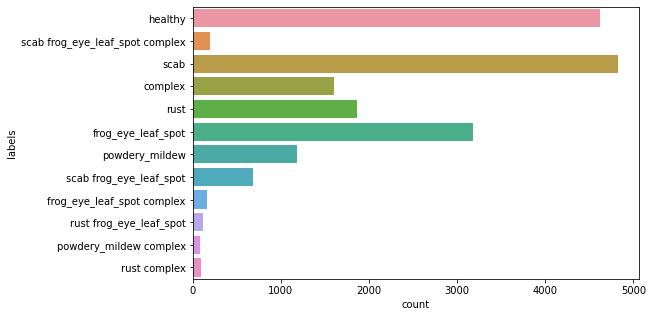

In [8]:
# 각 y변수가 몇개씩인지 그래프 그려보기
plt.figure(figsize=(8,5))
sns.countplot(data = df,y='labels')

In [9]:
# 그래프그리기함수
def plot_examples(label):
    #플롯사이즈설정
    fig, ax = plt.subplots(1, 5, figsize=(25, 15))
    ax=ax.ravel()
    for i in range(5):
        idx = df[df['labels']==label].index[i]
        
        image = cv2.imread(train_paths+df.loc[idx, 'image'])
        
        image =cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax[i].imshow(image)
        ax[i].set_title(label)
        ax[i].set_xticklabels([])
        ax[i].set_yticklabels([])

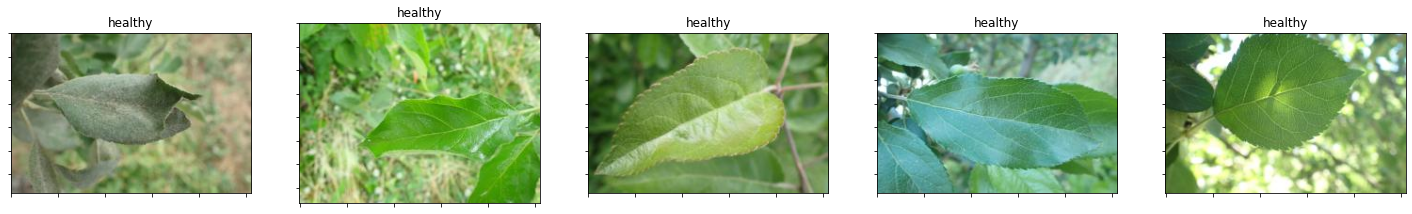

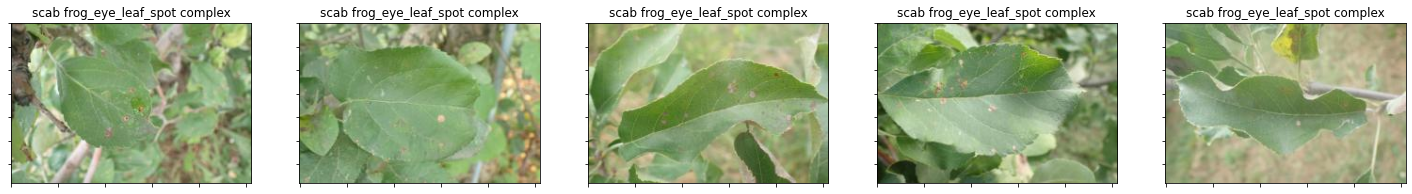

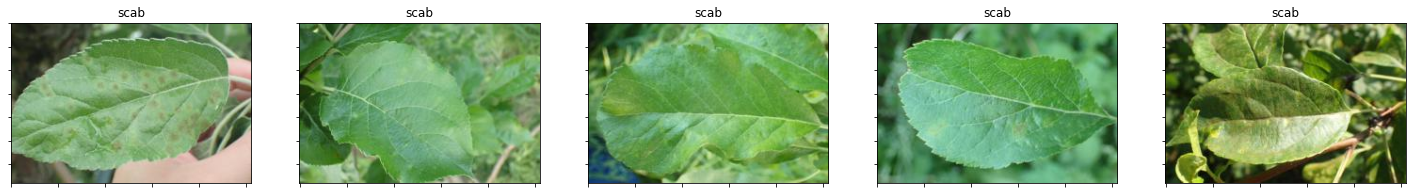

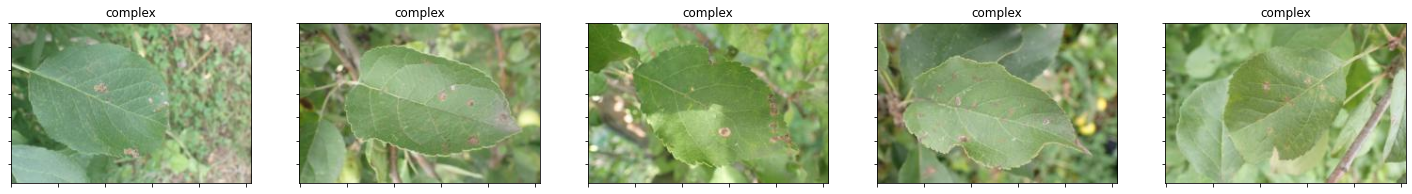

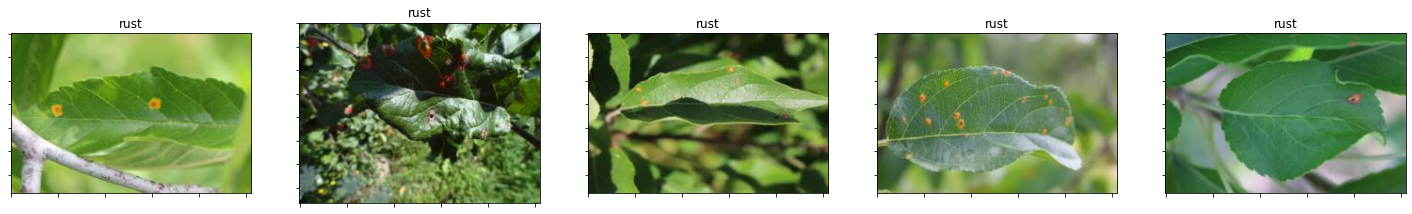

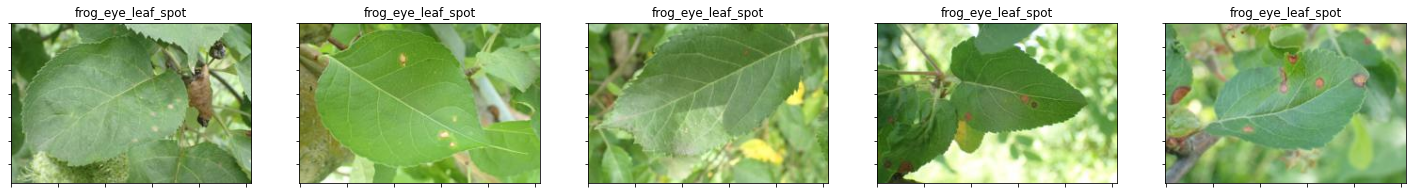

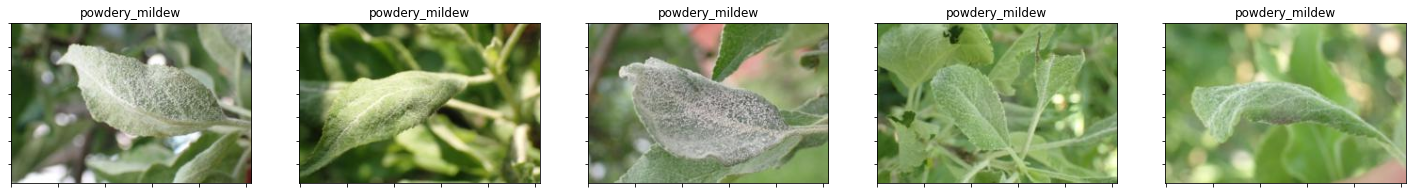

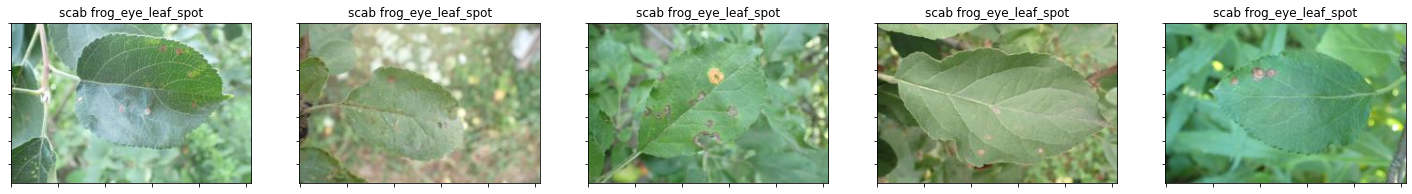

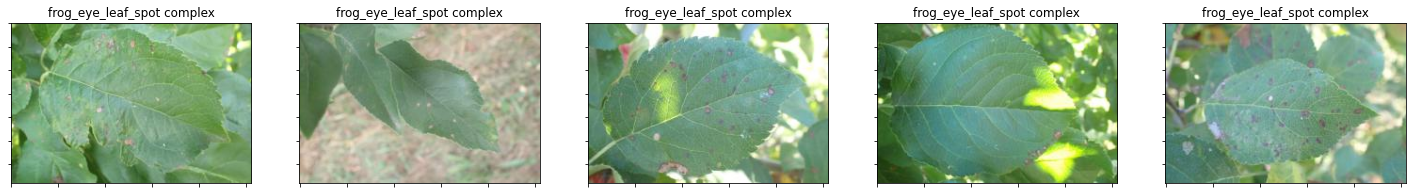

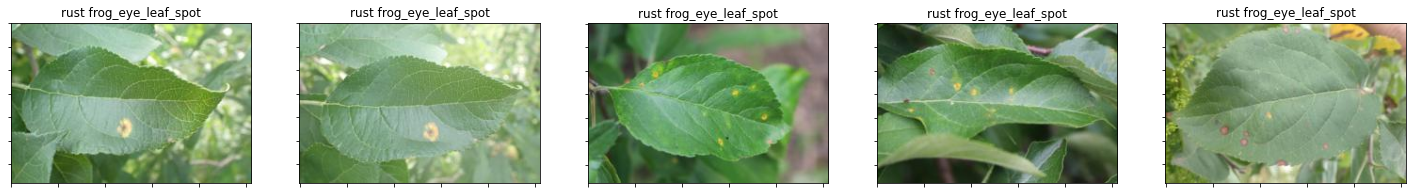

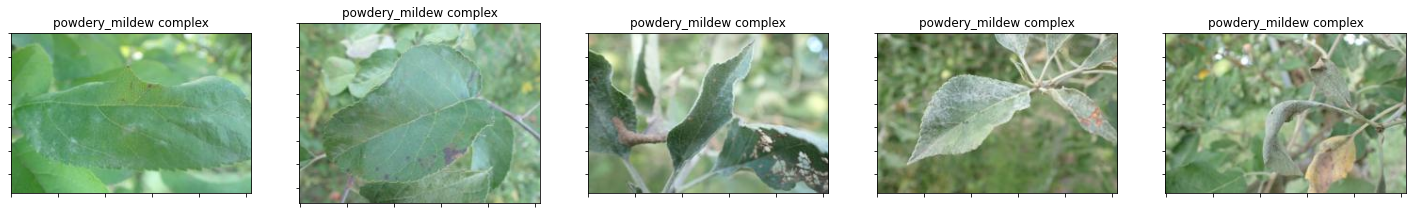

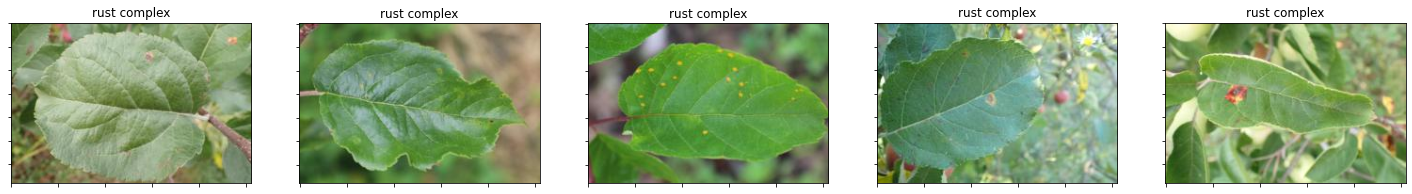

In [10]:
#플롯그리기
for labels in list(df['labels'].unique()):
    plot_examples(labels)

In [11]:
#라벨이 여러개가 겹쳐있는 경우를 해결
#우선 라벨 종류별 수를 센다
count_dict = df.labels.value_counts()
#라벨에 번호를 매기는 딕셔너리를 만듦
label2id = {
    'scab': 0,
    'frog_eye_leaf_spot' : 1,
    'rust' : 2,
    'complex' : 3,
    'powdery_mildew' : 4,
}
#라벨 종류수 세기
NUM_CLASS = len(label2id)
#아이템 디렉토리 만들기
id2label = dict([(value, key) for key, value in label2id.items()])
# 건강하지 않으면 단어간 사이 나누기
df["labels"] = df["labels"].map(lambda x : [i for i in x.split(" ") if i != "healthy"])
# 라벨들에 어떤 병이름이 붙었는지 다 넣기(수치화)
df["labels"] = df["labels"].map(lambda x : [label2id[i] for i in x])
df.head()

image     labels
0  800113bb65efe69e.jpg         []
1  8002cb321f8bfcdf.jpg  [0, 1, 3]
2  80070f7fb5e2ccaa.jpg        [0]
3  80077517781fb94f.jpg        [0]
4  800cbf0ff87721f8.jpg        [3]

In [12]:
#트레인 데이터 만들기
train_datagen = ImageDataGenerator(rescale = 1./255.,#크기조정
                                   rotation_range = 40,#회전
                                   width_shift_range = 0.2, #너비조정
                                   height_shift_range = 0.2,#높이 조정
                                   shear_range = 0.2,#
                                   zoom_range = 0.2,#확대
                                   horizontal_flip = True,#뒤집기
                                   validation_split = 0.2) 
#테스트데이터도 이렇게 만들기
test_datagen = ImageDataGenerator(rescale = 1./255,#크기조정
                                  validation_split = 0.2)

# Model Making

In [13]:
# 위에서 만든 트레인제너레이터 함수에다가 데이터프레임 넣기
train_generator = train_datagen.flow_from_dataframe(dataframe = df,#df넣기
                                                   directory = train_paths,#디렉토리
                                                   target_size = (256,256),#타겟 크기
                                                   x_col = 'image',#x축은 이미지
                                                   y_col = 'labels',#y축은 라벨(y변수)
                                                   batch_size = 128,#배치사이즈
                                                   color_mode = 'rgb', #색깔 모드
                                                   class_mode = 'categorical',#범주형으로 분류
                                                   subset = 'training')#트레이님
#테스트셋도 위와 같이 만들자
test_generator = test_datagen.flow_from_dataframe(dataframe = df,
                                                 directory = train_paths,
                                                 target_size = (256,256),
                                                 x_col = 'image',
                                                 y_col = 'labels',
                                                 batch_size = 128,
                                                 color_mode = 'rgb',
                                                 class_mode = 'categorical',
                                                 subset = 'validation')

Found 14906 validated image filenames belonging to 5 classes.
Found 3726 validated image filenames belonging to 5 classes.


In [14]:
#레이어를 쌓아 모델을 만들자
model = tf.keras.Sequential([
    # convolution으로 피처 찾기, 컨볼루션 필터의 수는 32개, 
    #컨볼루션 커널의 크기는 (3,3),샘플 수를 제외한 입력 형태는 (256,256)이고 채널수 3개,활성화함수는 relu
    tf.keras.layers.Conv2D(32, (3,3), input_shape=(256,256,3), activation='relu'),
    # feature map 크기 줄이고 불필요한 피처 제거 - (2,2)pooling layer 단위에서 가장 밝은 색상 추출
    tf.keras.layers.MaxPooling2D(2,2),
    #컨볼루션 필터 수는 64개, 커널 크기 (3,3),활성화함수는 relu
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # feature map 크기 줄이고 불필요한 피처 제거
    tf.keras.layers.MaxPooling2D(2,2),
    #컨볼루션 필터 수는 128개, 커널 크기 (3,3),활성화함수는 relu
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    # feature map 크기 줄이고 불필요한 피처 제거
    tf.keras.layers.MaxPooling2D(2,2),
    #컨볼루션 필터 수는 128개, 커널 크기 (3,3),활성화함수는 relu
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    # feature map 크기 줄이고 불필요한 피처 제거
    tf.keras.layers.MaxPooling2D(2,2),
    #컨볼루션 필터 수는 128개, 커널 크기 (3,3),활성화함수는 relu
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    # feature map 크기 줄이고 불필요한 피처 제거
    tf.keras.layers.MaxPooling2D(2,2),
    #레이어 평평하게
    tf.keras.layers.Flatten(),
    #컨볼루션 필터 수는 512개, 활성화함수는 relu
    tf.keras.layers.Dense(512, activation='relu'),
    #시그모이드활성화로 마지막 레이어형성
    tf.keras.layers.Dense(NUM_CLASS, activation='sigmoid')
])
model.summary() #모델 정보

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       1

In [15]:
# 점수매기기
METRIC = "val_f1_score"
# 콜백함수 설정
def create_callbacks(metric = METRIC):
    # 경로 설정
    cpk_path = './best_model.h5'
    #체크포인트 설정(중간저장)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=cpk_path, #파일명 지정
        monitor= metric, # metric일 때 호출
        mode='max', #max를 베스트로 찾음
        save_best_only=True,#베스트값만 저장
        verbose=1,#한번돌리자
    )
#학습률 설정
    reducelr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor= metric,
        mode='max',
        factor=0.2,#callback 호출시 학습률을 0.2로 줄입니다
        patience=3,#에폭시3번동안 개선안되면 호출
        verbose=1
    )
#얼리스타핑
    earlystop = tf.keras.callbacks.EarlyStopping(
        monitor= metric,
        mode='max',
        patience=10, #에폭시10번 돌리는동안 개선안되면 호출
        verbose=1
    )
    #콜백함수 내보내기
    callbacks = [checkpoint, reducelr, earlystop]         
    
    return callbacks

In [16]:
#케라스 옵티마이저중 RMSrop, adam 호출
from tensorflow.keras.optimizers import RMSprop,Adam
#애드온 임포트
import tensorflow_addons as tfa
#에폭시 설정
epochs = 20
#배치사이즈 설정
batch_size = 256
#옵티마이저는 아담
optimizer = Adam(lr = 0.001)
#모델 컴파일링
model.compile(optimizer = optimizer,
             loss = 'binary_crossentropy',#이걸로 로스 계산
             metrics = ['accuracy', tfa.metrics.F1Score(num_classes = NUM_CLASS,average = "macro", name = "f1_score")])

In [17]:
#모델 fit
callbacks = create_callbacks()
history = model.fit(train_generator,epochs = epochs,validation_data = test_generator,verbose=1, callbacks = callbacks)

Epoch 1/20
117/117 [==============================] - 318s 3s/step - loss: 0.4709 - accuracy: 0.4678 - f1_score: 0.1288 - val_loss: 0.4199 - val_accuracy: 0.5663 - val_f1_score: 0.1771

Epoch 00001: val_f1_score improved from -inf to 0.17707, saving model to ./best_model.h5
Epoch 2/20
117/117 [==============================] - 240s 2s/step - loss: 0.4029 - accuracy: 0.5115 - f1_score: 0.2133 - val_loss: 0.3840 - val_accuracy: 0.5658 - val_f1_score: 0.3523

Epoch 00002: val_f1_score improved from 0.17707 to 0.35235, saving model to ./best_model.h5
Epoch 3/20
117/117 [==============================] - 238s 2s/step - loss: 0.3722 - accuracy: 0.5512 - f1_score: 0.3761 - val_loss: 0.3501 - val_accuracy: 0.5491 - val_f1_score: 0.4305

Epoch 00003: val_f1_score improved from 0.35235 to 0.43052, saving model to ./best_model.h5
Epoch 4/20
117/117 [==============================] - 238s 2s/step - loss: 0.3304 - accuracy: 0.6561 - f1_score: 0.4865 - val_loss: 0.2848 - val_accuracy: 0.7238 - val_f

# 결과 분석

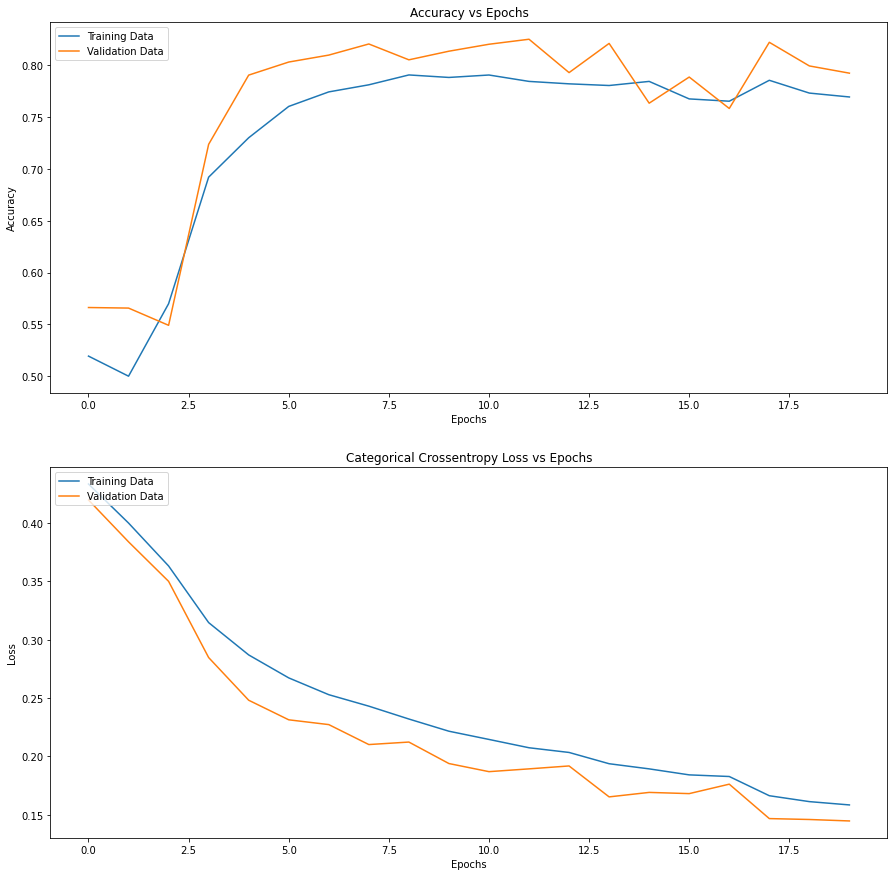

In [18]:
#플롯 그리기
figure, axis = plt.subplots(2, 1, figsize=(15,15))
axis.ravel()
# training 정확도, val 셋 정확도 각각 그리기
axis[0].plot(history.history['accuracy'],label='Training Data')
axis[0].plot(history.history['val_accuracy'], label='Validation Data')
#에폭시별 정확도
axis[0].set(xlabel='Epochs',ylabel='Accuracy', title='Accuracy vs Epochs')
axis[0].legend(loc="upper left")
#트레이닝셋, val셋 loss 그리기
axis[1].plot(history.history['loss'], label='Training Data')
axis[1].plot(history.history['val_loss'], label='Validation Data')
#에폭시별 로스
axis[1].set(xlabel='Epochs',ylabel='Loss', title='Categorical Crossentropy Loss vs Epochs')
axis[1].legend(loc="upper left")

plt.show()

In [24]:
#test파일 가져오기
test_dir = '/kaggle/input/plant-pathology-2021-fgvc8/test_images/'
test_df = pd.DataFrame()
test_df['image'] = os.listdir(test_dir)
#테스트셋 generate
test_set = test_datagen.flow_from_dataframe(dataframe=test_df,
                                    directory=test_dir,
                                    x_col="image",
                                    y_col=None,
                                    batch_size=64,
                                    seed=42,
                                    shuffle=False,
                                    class_mode=None,
                                    target_size=(256,256))
#예측
pred = model.predict(test_set).tolist()
#예측값 중 가장 큰 값 저장
for i in range(len(pred)):
    pred[i] = np.argmax(pred[i])

#분류되는 클래스만 뽑아서dict_Class라는 리스트 만들기
dict_classes = train_generator.class_indices


Found 3 validated image filenames.


'    \ndef get_key(val):\n    for key, value in dict_classes.items():\n        if val == value:\n            return key\n        \n\nfor i in range(len(pred)):\n    pred[i] = get_key(pred[i])\n    '

In [25]:
# 예측된 값이 어떤 클래스인지 클래스 리스트에서 가져오기
def get_key(val):
    for key, value in dict_classes.items():
        if val == value:
            return key
        
#prediction리스트를 클래스로 만들기
for i in range(len(pred)):
    pred[i] = get_key(pred[i])
    

In [26]:
#테스트셋 라벨을 pred으로 만들어서 대충 확인해보기
test_df['labels'] = pred
test_df

image  labels
0  ad8770db05586b59.jpg       3
1  c7b03e718489f3ca.jpg       1
2  85f8cb619c66b863.jpg       2

In [27]:
#제출파일 생성
test_df.to_csv('submission.csv', index=False)